# [LEGALST-190] Lab 4/12: Morality and Sentiment Analysis

This lab will cover morality and sentiment analysis using the *Moral Foundations Theory* with dictionary-based analysis, connecting to topic modeling and classifications ideas from previous labs.

### Table of Contents
[The Data](#section data)<br>
[Goal and Question](#section goal)<br>
1 - [Text Pre-processing](#section 1)<br>
2 - [General Sentiment Analysis](#section 2)<br>
3 - [Moral Foundations Theory](#section 3)<br>
4 - [Non-negative matrix factorization](#section 4)<br>

**Dependencies:**

In [230]:
import numpy as np
import pandas as pd
import seaborn as sns
import json

from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# import nltk
# from nltk.stem.snowball import SnowballStemmer
# from nltk.corpus import stopwords

----
## The Data<a id='section data'></a>

For this lab, we'll use Old Bailey `obc_1800_1850` dataset, something you all should be familiar with now. Because of its difficulty to clean, we've cleaned the data for you. The size of the dataset is also rather large so we will compare two 10-year periods, one from before 1827 and one after. Read the question to better understand why we look at 1827.

## Goal and Question<a id='section goal'></a>

The goal of today's lab is to explore sentiment analysis with three different approaches – [the Vader Model](#section 2), a specialized model dictionary ([Moral Foundations Theory](#section 3)), and [Non-negative matrix factorization](#section 4).

The question we want to answer is: 

**Did the way judges, prosecutors, and witnesses talk about moral culpability change after the Bloody Code was mostly repealed in 1827 (at the leading edge of a wave of legal reform in England)?**

Something to think about: What are some things you would need to consider before answering this question?

----

## Section 1: Text Pre-processing<a id='section 1'></a>

### Before we start
This dataset we are about to look at is incredibly large, so for this lab, we will select two years to look at, 1810 and 1840.

**Question 1.1:** Why are we looking at these two years?

*Write your answer here.*

----

### Getting started

Let's get working with the data. The `old bailey` data is under the name `obc_1800_1850.zip` in the data folder. 

**Question 1.2:** Retrieve the posts from the zip file and assign the list to a variable named `data`.

In [ ]:
import zipfile
zf = zipfile.ZipFile('data/obc_1800_1850.zip')
data = ...

data.head()

In [146]:
#SOLUTION
import zipfile

zf = zipfile.ZipFile('data/obc_1800_1850.zip')
data = pd.read_csv(zf.open('obc_1800_1850.csv'))
data.head()

,trial_id,offense,offense_subcategory,punishment,punishment_subcategory,session,transcript,verdict,verdict_subcategory
0,t18000115-1,violentTheft,highwayRobbery,uncategorized,none,18000115,"71. GEORGE GOWENS was indicted for that he, on...",notGuilty,none
1,t18000115-2,theft,burglary,death,none,18000115,72. JOHN MOORE was indicted for breaking and e...,guilty,none
2,t18000115-3,theft,animalTheft,death,none,18000115,73. HENRY WOODMAN was indicted for feloniously...,guilty,withRecommendation
3,t18000115-4,theft,burglary,uncategorized,none,18000115,74. JOHN EALEY was indicted for breaking and e...,notGuilty,none
4,t18000115-5,theft,housebreaking,death,none,18000115,75. JOHN BROWN was indicted for breaking and e...,guilty,none


Now let's pull out the data from between 1810 and 1840. You may have noticed from the table that both the *trial_id* and the *session* columns contain the date written in *yyyymmdd*. We will use *session* and check that it fits within our parameters. 

The only two columns we need to consider for this lab will be **session** and **transcript**.

**Question 1.3:** Parse through the dataframe to pull out the df for *session* and *transcript* and add a new column *date* that only contains the year for each incident. Remove *session* column.

In [ ]:
from datetime import datetime
from dateutil.parser import parse

df = df[[...]]

# HINT: Use parse similar to this: parse('18000115')
date = [... for ... in ...]

#add the date to the dataframe
df['date'] = date
df.drop('session', axis=1, inplace=True)

#check our status
df.head()

In [148]:
#SOLUTION
from datetime import datetime
from dateutil.parser import parse

df = data[['session','transcript']]

date = [parse(date) for date in df['session']]

df['date'] = date
df['date'] = df['date'].dt.year
df.head()

df.drop('session', axis=1, inplace=True)

df.head()

,transcript,date
0,"71. GEORGE GOWENS was indicted for that he, on...",1800
1,72. JOHN MOORE was indicted for breaking and e...,1800
2,73. HENRY WOODMAN was indicted for feloniously...,1800
3,74. JOHN EALEY was indicted for breaking and e...,1800
4,75. JOHN BROWN was indicted for breaking and e...,1800


**Question 1.4:** Create two new data subsets for before,1810, and after,1840, the year 1827.

In [ ]:
#remove the rows that aren't between 1810-1820 and save that to a new data frame
before_mask = (df['date'] ...)
before_1827 = df.loc[...]

#repeat for 1840-1850 in a new data frame
after_mask = (df['date'] ...)
after_1827 = df.loc[...]

In [175]:
#SOLUTION
before_mask = (df['date'] == 1810) 
# & (df['date'] <= 1815)
before_1827 = df.loc[before_mask]
# before_1827 = before_1827['transcript'].values

after_mask = (df['date'] == 1840)
# & (df['date'] <= 1845)
after_1827 = df.loc[after_mask]
# after_1827 = after_1827['transcript'].values

Awesome! We now have data we can work with. Before we start anything, we must clean the text!

Just to review, we want to process our text by:<br>
1) Lowercasing the words<br>
2) Cleaning up punctuation<br>

<a id='gensim'></a>**Question 1.5:** Clean up the data based on these two steps.

In [163]:
before_1827['transcript'] = before_1827['transcript']. ... #consider str.lower()
punct_re = r'[^\w\s]'
before_1827['transcript'] = before_1827['transcript']. ... #consider str.replace()

In [177]:
#SOLUTION
before_1827['transcript'] = before_1827['transcript'].str.lower()
punct_re = r'[^\w\s]'
before_1827['transcript'] = before_1827['transcript'].str.replace(punct_re, ' ')

In [ ]:
# follow the same format as before_1827
after_1827['transcript'] = ...
...
...

In [178]:
#SOLUTION
after_1827['transcript'] = after_1827['transcript'].str.lower()
punct_re = r'[^\w\s]'
after_1827['transcript'] = after_1827['transcript'].str.replace(punct_re, ' ')

In [115]:
# #Potential Solution
# stop = stopwords.words('english')
# punctuation = string.punctuation
# stemmer = SnowballStemmer("english")

# more_stops = ['--', '``', "''", "s'", "\'s", "n\'t", "...", "\'m", "-*-", "-|"] 
# before_1827_tokenized = []
# after_1827_tokenized = []
# for i in before_1827:
#     tokens = [word.lower() for sent in nltk.sent_tokenize(i) for word in nltk.word_tokenize(sent)]
#     filtered_tokens = [x for x in tokens if x not in punctuation and x not in more_stops]
#     stopped_tokens = [x for x in filtered_tokens if not x in stop]
#     stemmed_tokens = [stemmer.stem(i) for i in stopped_tokens]
#     before_1827_tokenized.append(stemmed_tokens)

# for i in after_1827:
#     tokens = [word.lower() for sent in nltk.sent_tokenize(i) for word in nltk.word_tokenize(sent)]
#     filtered_tokens = [x for x in tokens if x not in punctuation and x not in more_stops]
#     stopped_tokens = [x for x in filtered_tokens if not x in stop]
#     stemmed_tokens = [stemmer.stem(i) for i in stopped_tokens]
#     after_1827_tokenized.append(stemmed_tokens)

In [ ]:
# before_1827_tidy = pd.DataFrame()
# row = []
# for i in range(len(before_1827)):
#     row = [i]
#     for j in range(len(before_1827[i])):
#         row.append(j)
#         row.append(before_1827[i][j])
#         before_1827_tidy.append(row)
#         row = row[:1]

----

## Section 2: General Sentiment Analysis<a id='section 2'></a>

It turns out that we can use the words from Old Bailey to calculate a measure of the sentiment of the tweet. For example, the sentence "I love America!" has positive sentiment, whereas the sentence "I hate taxes!" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "I love America." is more positive than "I like America."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of Old Bailey. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which may or may not be great for our usage.

The VADER lexicon gives the sentiment of individual words. Run the following cell to show the first few rows of the lexicon:

In [169]:
print(''.join(open("data/vader_lexicon.txt").readlines()[:10]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



As you can see, the lexicon contains emojis too! The first column of the lexicon is the *token*, or the word itself. The second column is the *polarity* of the word, or how positive / negative it is.

(How did they decide the polarities of these words? What are the other two columns in the lexicon? See the link above.)

**Question 2.1:** Read in the lexicon into a DataFrame called `sent`. The index of the DF should be the tokens in the lexicon. `sent` should have one column: `polarity`: The polarity of each token.

In [ ]:
sent = ... #read_csv
sent.head()

In [171]:
sent = pd.read_csv('data/vader_lexicon.txt', sep='\t',
                   usecols=[0, 1], header=None, names=['token', 'polarity'],
                   index_col='token')
sent.head()

,polarity
token,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7


<a id='gensim'></a>**Question 2.2:** Create tidy formats of before and after 1827.

Now, let's convert the tweets into what's called a [*tidy format*](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) to make the sentiments easier to calculate. Use the `no_punc` column of `trump` to create a table called `tidy_format`. The index of the table should be the IDs of the tweets, repeated once for every word in the tweet. It has two columns:

1. `num`: The location of the word in the tweet. For example, if the tweet was "i love america", then the location of the word "i" is 0, "love" is 1, and "america" is 2.
2. `word`: The individual words of each tweet.

The first few rows of our `before_1827_tidy_format` table look like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>num</th>
      <th>word</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>7760</th>
      <td>0</td>
      <td>73</td>
    </tr>
    <tr>
      <th>7760</th>
      <td>1</td>
      <td>samuel</td>
    </tr>
    <tr>
      <th>7760</th>
      <td>2</td>
      <td>walker</td>
    </tr>
    <tr>
      <th>7760</th>
      <td>3</td>
      <td>was</td>
    </tr>
    <tr>
      <th>7760</th>
      <td>4</td>
      <td>indicted</td>
    </tr>
  </tbody>
</table>

* **Hint 1:** Try looking at the `expand` argument to pandas' `str.split`.
* **Hint 2:** Try looking at the `stack()` method.

In [ ]:
before_1827_tidy_format = (
    before_1827['transcript']
    ... #hint 1
    ... #hint 2
    .reset_index(level=1)
    .rename(columns={'level_1': 'num', 0: 'word'})
)

In [173]:
#SOLUTION
before_1827_tidy_format = (
    before_1827['transcript']
    .str.split(expand=True)
    .stack()
    .reset_index(level=1)
    .rename(columns={'level_1': 'num', 0: 'word'})
)
before_1827_tidy_format.head()

,num,word
7760,0,73
7760,1,samuel
7760,2,walker
7760,3,was
7760,4,indicted


In [ ]:
after_1827_tidy_format = (
    after_1827['transcript']
    ... #hint 1
    ... #hint 2
    .reset_index(level=1)
    .rename(columns={'level_1': 'num', 0: 'word'})
)

In [179]:
#SOLUTION
after_1827_tidy_format = (
    after_1827['transcript']
    .str.split(expand=True)
    .stack()
    .reset_index(level=1)
    .rename(columns={'level_1': 'num', 0: 'word'})
)
after_1827_tidy_format.head()

,num,word
60597,0,396
60597,1,james
60597,2,youngwas
60597,3,indicted
60597,4,for


Now that we have this table in the tidy format, it becomes much easier to find the sentiment of each statement: we can join the table with the lexicon table. 

**Question 2.3:** Add a `polarity` column to the `before_1827` and `after_1827` table.  The `polarity` column should contain the sum of the sentiment polarity of each word in the text.

**Hint** you will need to merge the `before_1827_tidy_format` or `after_1827_tidy_format` and `sent` tables and group the final answer.

In [ ]:
before_1827['polarity'] = ...
before_1827.head()

In [191]:
before_1827['polarity'] = (
    before_1827_tidy_format
    .merge(sent, how='left', left_on='word', right_index=True)
    .reset_index()
    .loc[:, ['index', 'polarity']]
    .groupby('index')
    .sum()
    .fillna(0)
)
before_1827.head()

,transcript,date,polarity
7760,73 samuel walker was indicted for that he fe...,1810,-10.6
7761,74 robert francis was indicted for burglariou...,1810,-10.7
7762,75 john anderson was indicted for that he on...,1810,-28.7
7763,76 george hand was indicted for burglariously...,1810,-37.2
7764,77 charles cadman was indicted for that he ...,1810,-5.0


In [ ]:
after_1827['polarity'] = ...
after_1827.head()

In [193]:
after_1827['polarity'] = (
    after_1827_tidy_format
    .merge(sent, how='left', left_on='word', right_index=True)
    .reset_index()
    .loc[:, ['index', 'polarity']]
    .groupby('index')
    .sum()
    .fillna(0)
)
after_1827.head()

,transcript,date,polarity
60597,396 james youngwas indicted for a misdemeanor...,1840,-52.7
60598,397 michael quinwas indicted for stealing on...,1840,-19.3
60599,398 john harwoodwas indicted for stealing on...,1840,-1.9
60600,399 thomas buttonwas indicted for stealing o...,1840,5.1
60601,400 mary lockewas indicted for stealing on t...,1840,-22.6


Now we have a measure of the sentiment of each of statement! Note that this calculation is rather basic; you can read over the VADER readme to understand a more robust sentiment analysis.

Now, run the cells below to see the most positive and most negative statements from Old Bailey in your two datasets:

In [188]:
print('Most positive statement 1810:')
for t in before_1827.sort_values('polarity').head()['transcript']:
    print('\n  ', t)

Most positive statement 1810:

   291  samuel lovetrue was indicted for feloniously stealing  on the 2nd of april  7 pieces of foreign gold coin called louis d ors  value 7 l  3 guineas  2 dollars  and 2 shillings   the property of peter strihben   peter strihben   q  what countryman are you   a  i come from riga  last sunday week the ship arrived here  and then i came on shore q  did you come from riga  or from what other place   a  i came from heligoland  i was in an accompting house there  i came from there to london  thinking of finding some of my relations here  and then to go home to riga q  what place did you come on shore   a  i landed at a bridge that took me to wapping  i wanted to go to mr  warren s a publican in st  catharine s  i enquired the way to that publican  on my going along the prisoner stood at a shop door i asked him to give me change for a guinea  i wanted to buy something if i could have got change q  what language did the prisoner speak to you in   a  english 

In [194]:
print('Most negative statement 1840:')
for t in after_1827.sort_values('polarity').head()['transcript']:
    print('\n  ', t)

Most negative statement 1840:

   1629  francois benjamin courvoisierwas indicted for the wilful murder of william russell  esq   commonly called lord william russell messrs  adolphus  bodkin  andchambersconducted the prosecution sarah manser i was in the employment of the late lord william russell  as housemaid  âœ  for three yearsâ  he resided at no  14  norfolkstreet  park laneâ  a cook and valet were the only other servantsâ  the prisoner was the valetâ  the cook had been two years and nine months in his lordship s serviceâ  those were all the in door servants his lordship keptâ  he had also a coachman and groom who did not live in the houseâ  his lordship was a widower  and lived alone  on tuesday morning  the 5th of may  i saw his lordship a little before nine o clockâ  he came down before breakfastâ  he went out at one o clockâ  the prisoner had been in attendance on him all the morningâ  after his lordship had gone out  the prisoner said lord russell had given him five messages

**Question 2.4:** Let's take a look at violin plots of these two datasets to better compare how the sentiment is between the two dates, before and after 1827.

In [ ]:
old_bailey = ... #append the two dataframes
old_bailey_violin = ... #call sns.violinplot

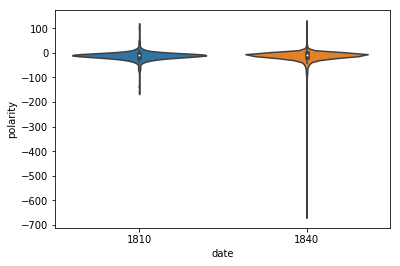

In [199]:
#SOLUTION
old_bailey = before_1827.append(after_1827)
old_bailey_violin = sns.violinplot(x="date", y="polarity", data=old_bailey)

What are some pros to this type of approach? Cons?

*Write your answer here.*

----
## Section 3: Moral Foundations Theory<a id='section 3'></a>

Something to consider when looking at sentiment, outside of just general polarity like we did in the last section, people can create specialized dictionaries containing specific words of interest to try to analyze sentiment from a particular angle. One organization, the [Moral Foundations Theory](http://moralfoundations.org/), took this approach and we will now use it to see if we can understand Old Bailey's sentiment better. You should be doing something like this for your homework. We will be using a provided moral foundations dictionary.

In [202]:
with open('data/haidt_dict.json') as json_data:
    haidt_dict = json.load(json_data)

In [213]:
#look at the keys of the dictionary provided
keys = haidt_dict.keys()
list(keys)

['authority/subversion',
 'care/harm',
 'fairness/cheating',
 'loyalty/betrayal',
 'sanctity/degradation']

In [212]:
haidt_dict[list(keys)[0]] #one example of the values provided for the first key

['preserve',
 'loyal',
 'betray',
 'treason',
 'traitor',
 'treacher',
 'disloyal',
 'apostasy',
 'apostate',
 'deserted',
 'deserter',
 'deserting',
 'obey',
 'obedien',
 'duty',
 'law',
 'lawful',
 'legal',
 'duti',
 'honor',
 'respect',
 'respectful',
 'respected',
 'respects',
 'order',
 'father',
 'mother',
 'motherl',
 'mothering',
 'mothers',
 'tradition',
 'hierarch',
 'authorit',
 'permit',
 'permission',
 'status',
 'rank',
 'leader',
 'class',
 'bourgeoisie',
 'caste',
 'position',
 'complian',
 'command',
 'supremacy',
 'control',
 'submi',
 'allegian',
 'serve',
 'abide',
 'defere',
 'defer',
 'revere',
 'venerat',
 'comply',
 'defian',
 'rebel',
 'dissent',
 'subver',
 'disrespect',
 'disobe',
 'sediti',
 'agitat',
 'insubordinat',
 'illegal',
 'lawless',
 'insurgent',
 'mutinous',
 'defy',
 'dissident',
 'unfaithful',
 'alienate',
 'defector',
 'heretic',
 'nonconformist',
 'oppose',
 'protest',
 'refuse',
 'denounce',
 'remonstrate',
 'riot',
 'obstruct']

**Question 3.1**: Read through the document and write what you think.

*Write your answer here.*

Now that we have our `old_bailey` data and a dictionary, we can start our exploratory analysis.

To get a sense of how Moral Foundations words were used in statements, we'll do three things:

1) Count the occurances of words from our dictionary in each statement<br>
2) Calculate how often words from each category are used by in each year<br>
3) Plot the percents on a bar graph<br>

Think about what you know about Moral Foundations Theory.

### Calculating Percentages 

We're interesting in knowing the percent of words that correspond to a Moral Foundation in speeches- in other words, how often statements contained words related to a specific foundation.

(Bonus question: why don't we just use the number of Moral Foundation words instead of the percent as our test statistic?)

**Question 3.2:** To calculate the percent, we'll first need the total number of words in each statement.

In [ ]:
# create a new column called 'total_words'
old_bailey['total_words'] = ...
old_bailey.head()

In [203]:
# SOLUTION
old_bailey['total_words'] = [len(statement) for statement in old_bailey['transcript']]
old_bailey.head()

,transcript,date,polarity,total_words
7760,73 samuel walker was indicted for that he fe...,1810,-10.6,11552
7761,74 robert francis was indicted for burglariou...,1810,-10.7,3065
7762,75 john anderson was indicted for that he on...,1810,-28.7,2451
7763,76 george hand was indicted for burglariously...,1810,-37.2,3160
7764,77 charles cadman was indicted for that he ...,1810,-5.0,296


Next, we need to calculate the number of matches to entries in our dictionary for each foundation for each speech.

Run the next cell to add six new columns to `old_bailey`, one per foundation, that show the number of word matches.

In [204]:
#Note: much of the following code is not covered in these modules. Read the comments to get a sense of what it does.
#Will take a bit of time to run due to the large size.

# do the following code for each foundation
for foundation in haidt_dict.keys():
    # create a new, empty column
    num_match_words = np.zeros(len(old_bailey))
    stems = haidt_dict[foundation]
    
    # do the following code for each foundation word
    for stem in stems:
        # find synonym matches
        wd_count = np.array([sum([wd.startswith(stem) for wd in statement]) for statement in old_bailey['transcript']])
        # add the number of matches to the total
        num_match_words += wd_count
        
    # create a new column for each foundation with the number of foundation words per speech
    old_bailey[foundation] = num_match_words

old_bailey.head()

,transcript,date,polarity,total_words,authority/subversion,care/harm,fairness/cheating,loyalty/betrayal,sanctity/degradation
7760,73 samuel walker was indicted for that he fe...,1810,-10.6,11552,0.0,0.0,0.0,0.0,0.0
7761,74 robert francis was indicted for burglariou...,1810,-10.7,3065,0.0,0.0,0.0,0.0,0.0
7762,75 john anderson was indicted for that he on...,1810,-28.7,2451,0.0,0.0,0.0,0.0,0.0
7763,76 george hand was indicted for burglariously...,1810,-37.2,3160,0.0,0.0,0.0,0.0,0.0
7764,77 charles cadman was indicted for that he ...,1810,-5.0,296,0.0,0.0,0.0,0.0,0.0


**Question 3.3:** To calculate the percentage of foundation words per speech, divide the number of matched words by the number of total words and multiply by 100.

In [ ]:
for foundation in haidt_dict.keys():
    old_bailey[foundation] = ...

old_bailey.head()

In [214]:
#SOLUTION
for foundation in haidt_dict.keys():
    old_bailey[foundation] = (old_bailey[foundation] / old_bailey['total_words']) * 100

old_bailey.head()

,transcript,date,polarity,total_words,authority/subversion,care/harm,fairness/cheating,loyalty/betrayal,sanctity/degradation
7760,73 samuel walker was indicted for that he fe...,1810,-10.6,11552,0.0,0.0,0.0,0.0,0.0
7761,74 robert francis was indicted for burglariou...,1810,-10.7,3065,0.0,0.0,0.0,0.0,0.0
7762,75 john anderson was indicted for that he on...,1810,-28.7,2451,0.0,0.0,0.0,0.0,0.0
7763,76 george hand was indicted for burglariously...,1810,-37.2,3160,0.0,0.0,0.0,0.0,0.0
7764,77 charles cadman was indicted for that he ...,1810,-5.0,296,0.0,0.0,0.0,0.0,0.0


**Question 3.4:** Is there anything strange you notice?

*Write your answer here.*

Let's separate the two dates, 1810 and 1840, again like we did earlier in the lab. Then we will create two bar graphs.

**Question 3.5:** Make a table `transcript_1810` and a table `transcript_1840` so we can compare the two datasets separately. Then create two separate bar graphs for the two datasets.

In [ ]:
transcript_1810 = ...

# select the foundations columns and calculate the mean percent for each
avg_1810_stats = (transcript_1810.loc[:, ...]
                 .apply(np.mean)
                 .to_frame('1810_percent'))

avg_1810_stats

In [216]:
#SOLUTION
transcript_1810 = old_bailey[old_bailey['date'] == 1810]

# select the foundations columns and calculate the mean percent for each
avg_1810_stats = (transcript_1810.loc[:, list(haidt_dict.keys())]
                 .apply(np.mean)
                 .to_frame('1810_percent'))

avg_1810_stats

,1810_percent
authority/subversion,0.0
care/harm,0.0
fairness/cheating,0.0
loyalty/betrayal,0.0
sanctity/degradation,0.0


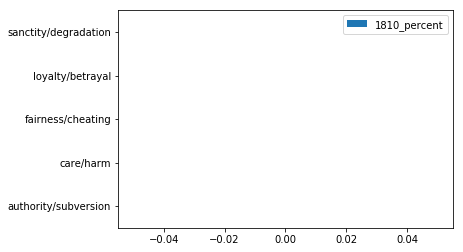

In [218]:
avg_1810_stats.plot.barh();

In [ ]:
transcript_1840 = ...

# select the foundations columns and calculate the mean percent for each
avg_1840_stats = (transcript_1840.loc[:, ...]
                 .apply(np.mean)
                 .to_frame('1840_percent'))

avg_1840_stats

In [221]:
#SOLUTION
transcript_1840 = old_bailey[old_bailey['date'] == 1840]

# select the foundations columns and calculate the mean percent for each
avg_1840_stats = (transcript_1840.loc[:, list(haidt_dict.keys())]
                 .apply(np.mean)
                 .to_frame('1840_percent'))

avg_1840_stats

,1840_percent
authority/subversion,0.0
care/harm,0.0
fairness/cheating,0.0
loyalty/betrayal,0.0
sanctity/degradation,0.0


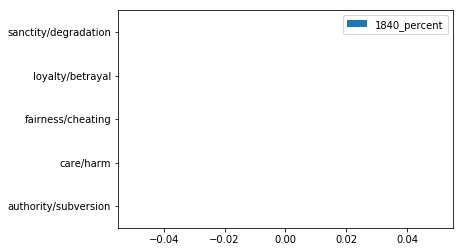

In [222]:
avg_1840_stats.plot.barh();

In [ ]:
all_avg_stats = ...
all_avg_stats

In [224]:
#SOLUTION
all_avg_stats = avg_1810_stats.join(avg_1840_stats)
all_avg_stats

,1810_percent,1840_percent
authority/subversion,0.0,0.0
care/harm,0.0,0.0
fairness/cheating,0.0,0.0
loyalty/betrayal,0.0,0.0
sanctity/degradation,0.0,0.0


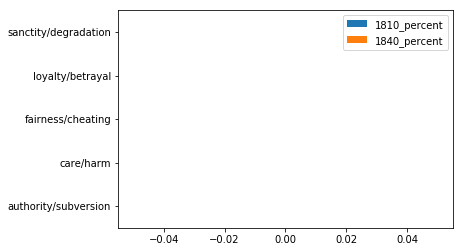

In [227]:
all_avg_stats.plot.barh();

**Question 3.6:** What are some pros of this method? Cons?

*Write your answer here.*

*Potential answer: Rarity of words means results may not be significant.*

----
## Section 4: Non-negative matrix factorization<a id='section 4'></a>

In this section, you can get an idea of sentiment using topic modeling algorithsm, something you touched on in the 4/10 lab earlier this week, to help look for patterns.

The creation of the bag of words matrix is very easy in Scikit Learn with all of the heavy lifting done by the feature extraction functionality provided for text datasets. A tf-idf transformer is applied to the bag of words matrix that NMF must process with the TfidfVectorizer. Stop words are removed and the number of terms included in the bag of words matrix is restricted to the top 1000.

**Question 4.1:** Fill in the elipses so we can create a tfidf for our NMF.

**Hint:** Look up the code for TfidfVEctorizer to better understand what this code is doing. 

In [ ]:
no_features = ...

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=..., stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(...) #add the column with the statements
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [240]:
#SOLUTION
no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(old_bailey['transcript'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

As mentioned previously the algorithms are not able to automatically determine the number of topics and this value must be set when running the algorithm. Initialising the W and H matrices in NMF with ‘nndsvd’ rather than random initialisation improves the time it takes for NMF to converge.

**Question 4.2:** Fill in the number of components we use and what we are fitting our NMF on.

In [ ]:
no_topics = 20
# Run NMF
nmf = NMF(n_components=..., random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(...)

In [241]:
#SOLUTION
no_topics = 20
# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

We've provided you the function to display the topics shown by the NMF.

In [239]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
prisoner pawnbroker pawned took missed police live shawl constable james
Topic 1:
pleadedguilty confined months aged indicted goods stealing william james master
Topic 2:
handkerchief pocket person handkerchiefâ saw pocketâ gentleman felt hand prosecutor
Topic 3:
value 1s 6d 2s goods 3s 4s 5s 10s 1l
Topic 4:
mr jury property feloniously middlesex recorder prisoner value second common
Topic 5:
watch chain seal gold prosecutor key value person man house
Topic 6:
mr did money paid examined cross account prisoner received receive
Topic 7:
half crown shilling gave counterfeit bad shillings sixpence crowns money
Topic 8:
house went room did door bed box night yes things
Topic 9:
transported years pleadedguilty seven convicted felony aged goods indicted stealing
Topic 10:
coat coatâ waistcoat 10s value great cart trowsers coats pair
Topic 11:
boots pair shoes trowsers pairs themâ shop stockings value john
Topic 12:
saw shop ran prisoner street took yards stop thief door
Topic 13:
sai

**Question 4.3:** Now what did you think of this approach? It should be similar to what you learned before so we don't go into too much depth with it. Are there any pros and cons you might consider?

*Write your answer here.*

*Potential answer: Unstructured data means you might have to dig a lot to find relevant topics.*

----
Fantastic! Now you know how to cover morality and sentiment analysis two ways using general sentiment analysis with `VADER`, Moral Foundations Theory, and Non-negative matrix factorization.

Now see if you can answer our main question of today: 

**Question:** Did the way judges, prosecutors, and witnesses talk about moral culpability change after the Bloody Code was mostly repealed in 1827 (at the leading edge of a wave of legal reform in England)?

----

## Bibliography

 - Work done with text analysis. https://github.com/DS-100/sp18/blob/master/proj/proj1/solution/proj1_solution.ipynb
 - *Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.*
 - Moral Foundations Theory background: http://moralfoundations.org/
 - Moral Foundations analysis https://github.com/ds-modules/XRHETOR-R1A/blob/master/02-Moral-Foundations-Analysis/02-Moral-Foundations-Analysis.ipynb

----
Notebook developed by: Gibson Chu

Data Science Modules: http://data.berkeley.edu/education/modules